In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from os import listdir
from os.path import isfile, join
import imutils


image = 1
mypath = '../data/imagesprojets5/photo/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
onlyfiles

['image_1_1.jpg',
 'image_1_2.jpg',
 'image_1_3.jpg',
 'image_2_1.jpg',
 'image_2_2.jpg',
 'image_2_3.jpg',
 'image_2_4.jpg',
 'image_2_5.jpg',
 'image_3_1.jpg']

In [4]:
img_file = onlyfiles[4]
origin_file = '../data/imagesprojets5/originals/image_1.jpg' 

In [7]:
img = cv2.imread(mypath + img_file)
origin = cv2.imread(origin_file)

Text(0.5, 1.0, 'origin image')

<Figure size 720x720 with 0 Axes>

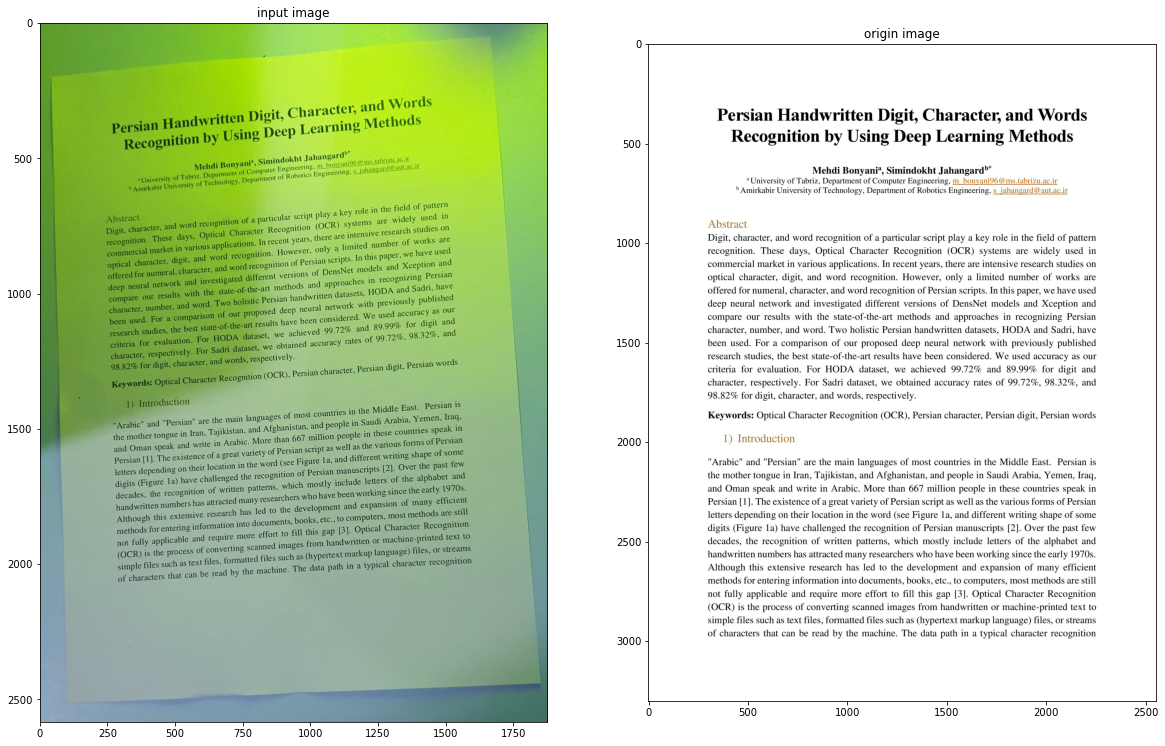

In [8]:
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(img)
ax1.set_title('input image')
ax2.imshow(origin)
ax2.set_title('origin image')

Text(0.5, 1.0, 'result_norm_planes')

<Figure size 720x720 with 0 Axes>

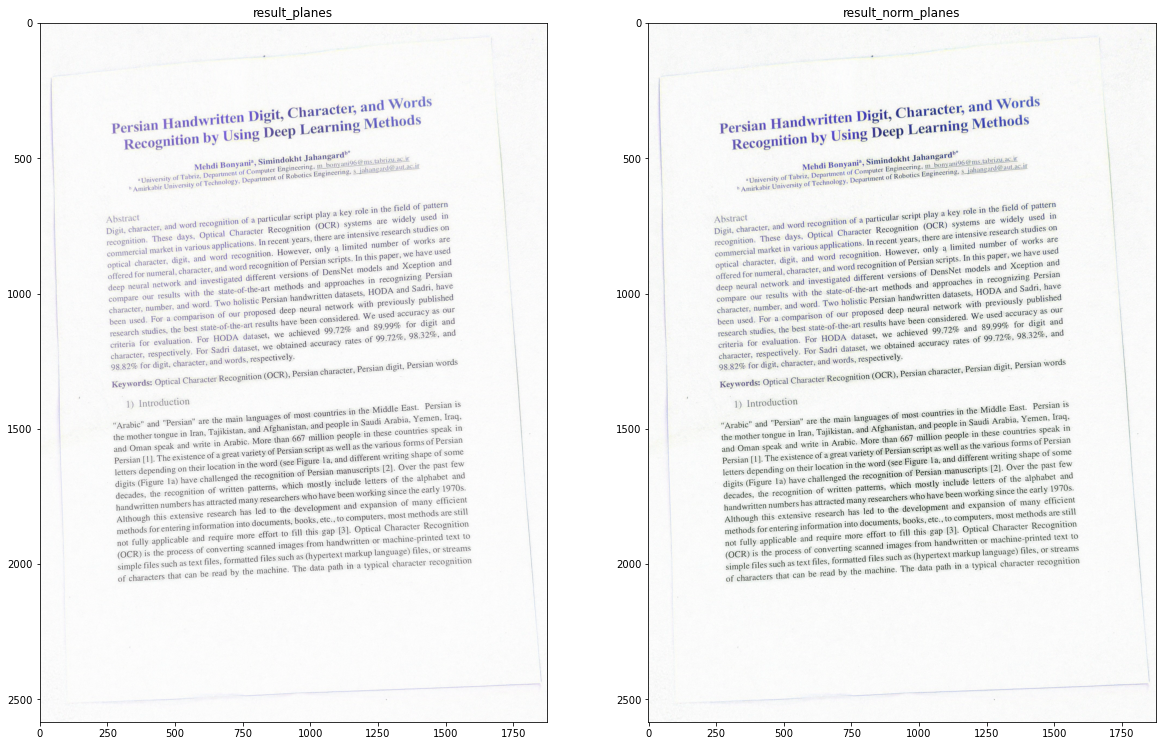

In [30]:

rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(result)
ax1.set_title('result_planes')
ax2.imshow(result_norm)
ax2.set_title('result_norm_planes')

In [31]:
# convert to grayscale
gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

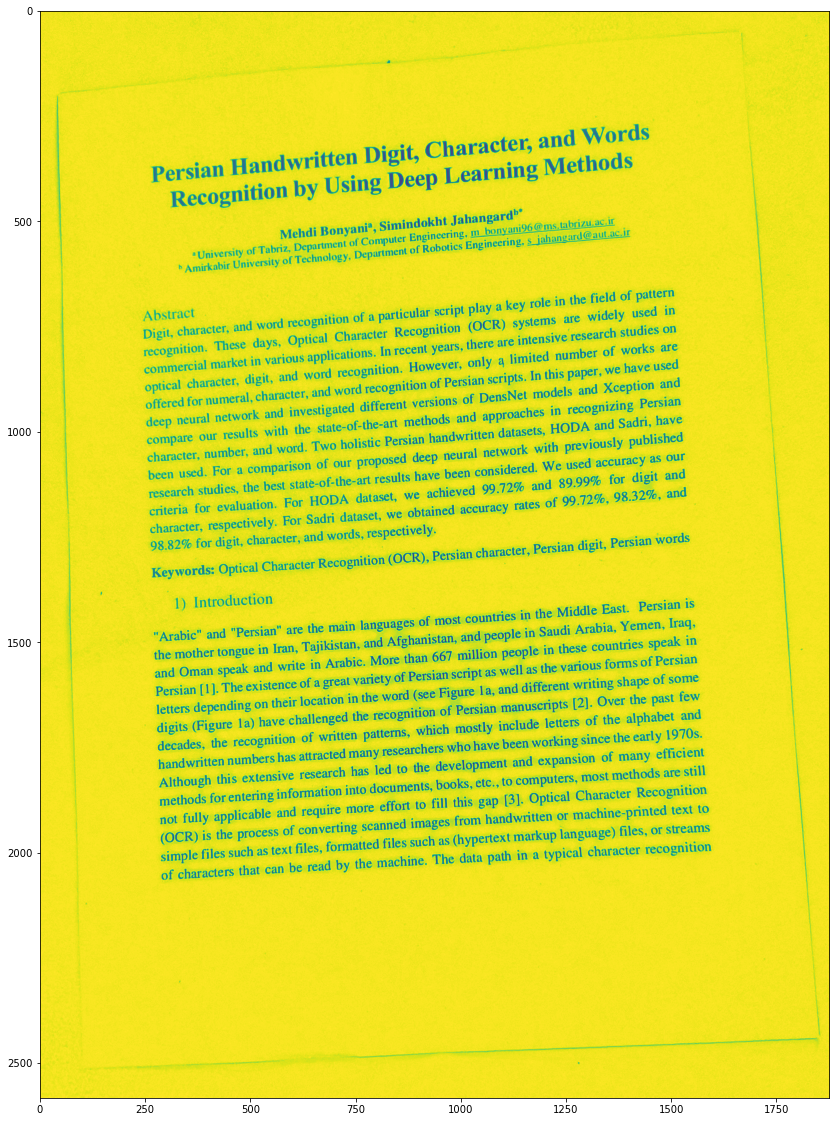

In [32]:
plt.imshow(gray)

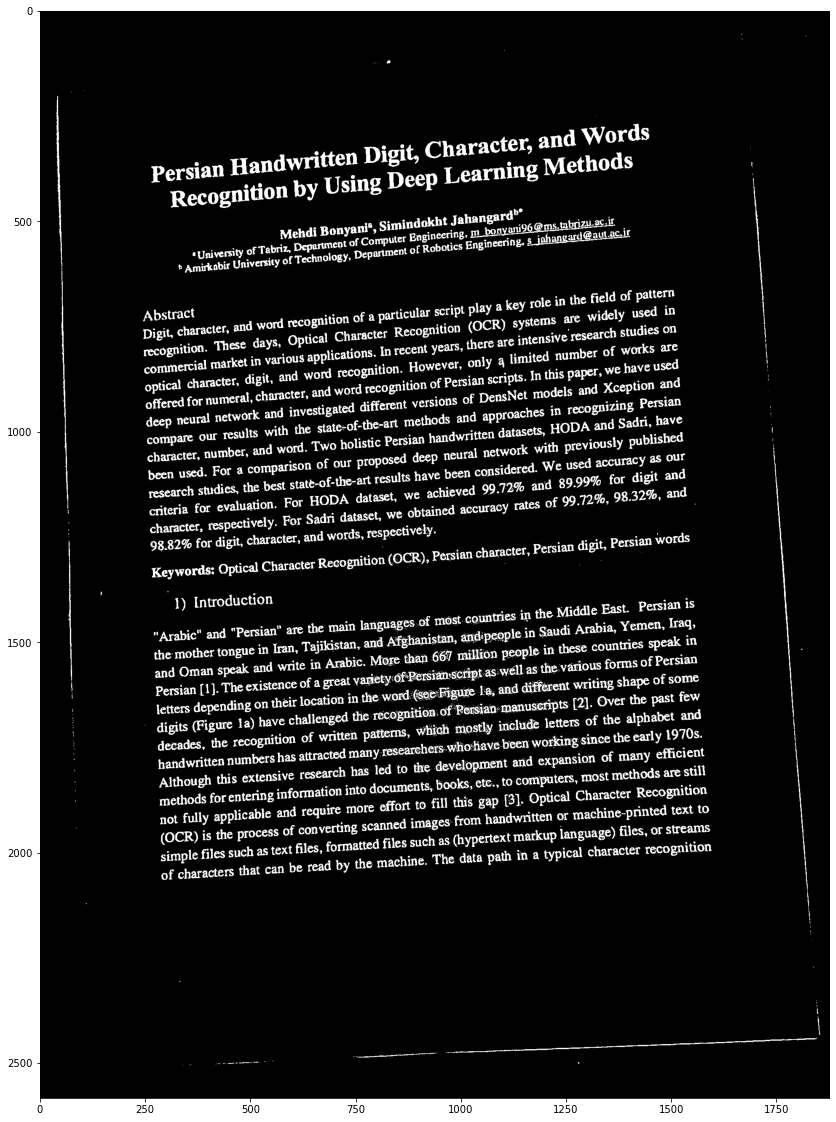

In [33]:
# create a binary thresholded image
_, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)
# show it
plt.imshow(binary, cmap="gray")
plt.show()

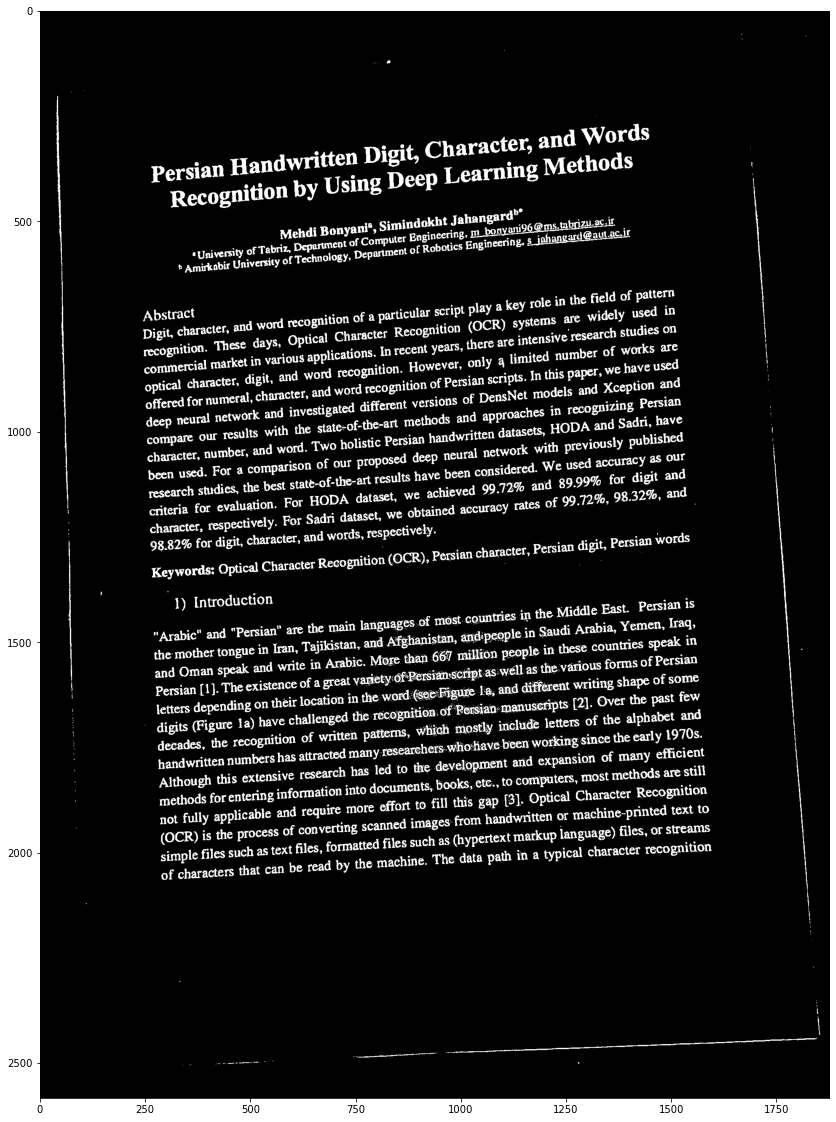

In [34]:
# create a binary thresholded image
_, binary = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)
# show it
plt.imshow(binary, cmap="gray")
plt.show()

In [37]:
# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(result, contours, -1, (0, 255, 0), 2)

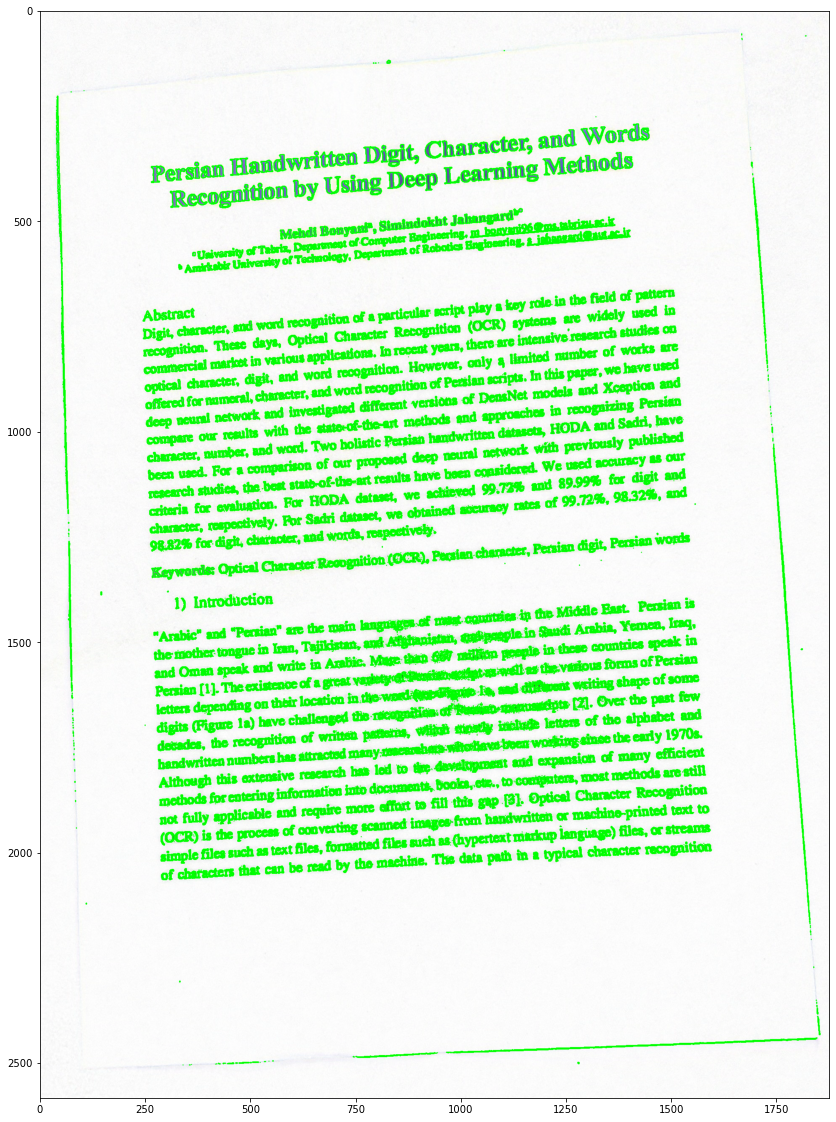

In [38]:
# show the image with the drawn contours
plt.imshow(image)
plt.show()

In [39]:
img = result.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

In [40]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

In [42]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)

In [43]:
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

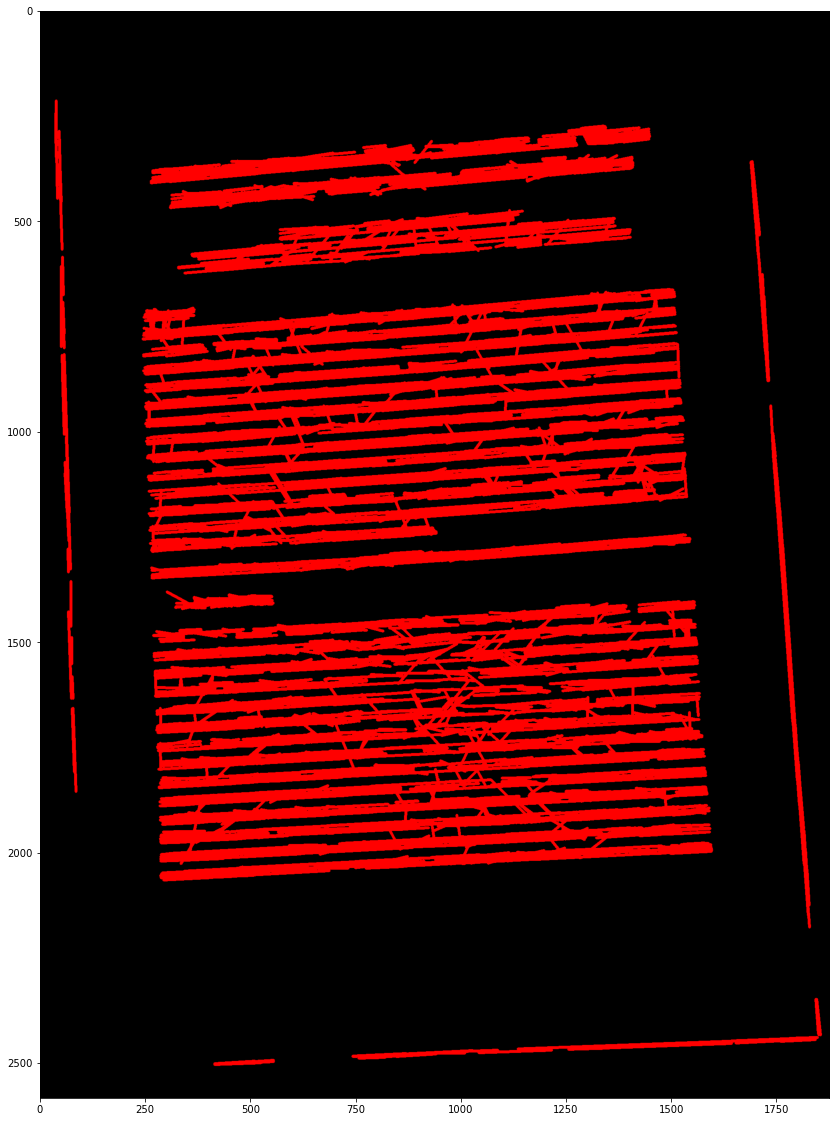

In [45]:
plt.imshow(line_image)

In [49]:
line_image.shape

(2583, 1875, 3)

In [51]:
lines.shape

(3204, 1, 4)

In [67]:
lines_r = lines.reshape(3204,4)

In [71]:
lines_r[0:10]

array([[1288, 1814, 1577, 1799],
       [ 886,  510,  894,  578],
       [ 334, 2026,  375, 1958],
       [ 680, 1936, 1187, 1909],
       [1017, 1064, 1063, 1001],
       [1421, 1428, 1552, 1419],
       [1774, 1514, 1797, 1829],
       [  53,  586,   55,  676],
       [ 842, 1249,  894, 1185],
       [ 300, 1071, 1079, 1017]], dtype=int32)

### solution one (partial):
- find the highest vector direction in the image, it will correspond to the text in the image.
- rotate it so that it becomes horizontal
- crop the image in the areas where the lines with the corresponding direction end + a buffer.

In [141]:
angles = []
angles_with_no_inf = []
for line in lines:
    for x1,y1,x2,y2 in line:
        angle = (y2-y1)/(x2-x1)
        if abs(angle) != np.inf:
            angles_with_no_inf.append(angle)
        angles.append(angle)
angles = np.array(angles)
angles_with_no_inf = np.array(angles_with_no_inf)

<ipython-input-141-ab36314d1280>:5: RuntimeWarning: divide by zero encountered in int_scalars
  angle = (y2-y1)/(x2-x1)


In [142]:
angles_mean = angles_with_no_inf.mean()

In [145]:
angle_perc_difference = (angles - angles_mean)/angles_mean
angle_perc__with_no_inf_difference = (angles_with_no_inf - angles_mean)/angles_mean


<AxesSubplot:ylabel='Density'>

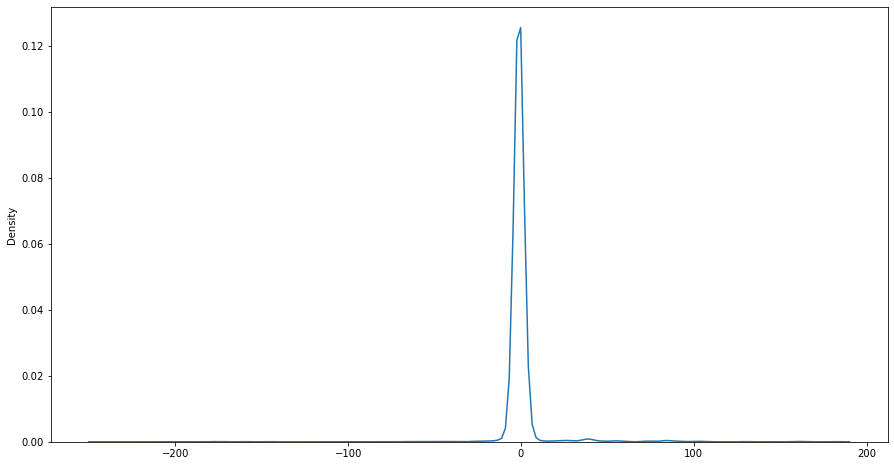

In [146]:
import seaborn as sns
plt.figure(figsize=(15,8))
sns.kdeplot(angle_perc__with_no_inf_difference)

In [140]:
angle_perc_difference.shape

(3198,)

In [163]:
lines_candidates = lines_r[abs(angle_perc_difference) < 0.5,:]

In [164]:
lines_candidates = lines_candidates.reshape(lines_candidates.shape[0],1,lines_candidates.shape[1])

In [165]:
line_image_candidates = np.copy(img) * 0  # creating a blank to draw lines on
for line in lines_candidates:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_candidates,(x1,y1),(x2,y2),(255,0,0),5)

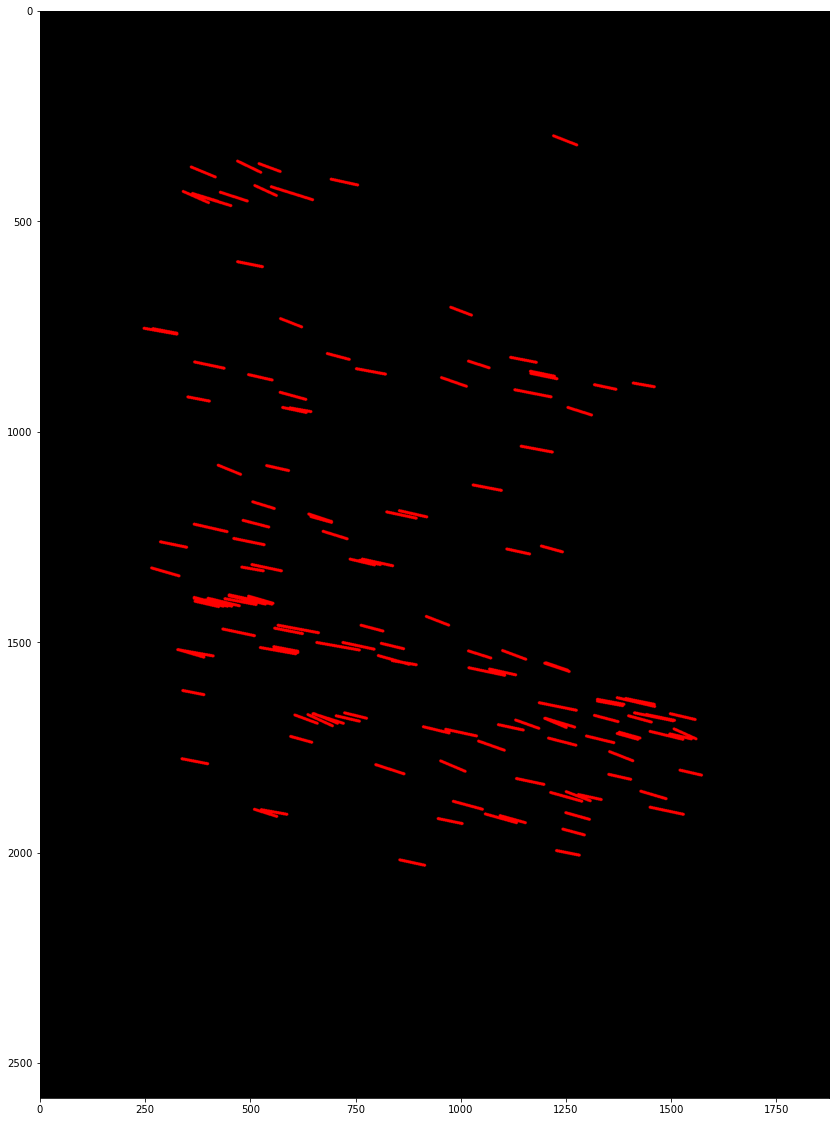

In [166]:
plt.imshow(line_image_candidates)

### Solution 2 
- Find the highest vector direction 
- find the image contours with auto-completion
- compute the homography matrix
- apply the homography transformation on the image

In [ ]:
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

In [ ]:
def deskew(_img):
    #image = io.imread(_img)
    grayscale = rgb2gray(_img)
    angle = determine_skew(grayscale)
    rotated = rotate(_img, angle, resize=True) * 255
    print(angle)
    return rotated.astype(np.uint8)

In [ ]:
def display_avant_apres(_original):
    plt.subplot(1, 2, 1)
    plt.imshow(_original)
    plt.subplot(1, 2, 2)
    plt.imshow(deskew(_original))